In [3]:

import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
#import pymc3 as pm
import scipy
import scipy.stats as stats
import seaborn.apionly as sns

from IPython.display import Image
from sklearn import preprocessing


%matplotlib inline
plt.style.use('bmh')
colors = ['#348ABD', '#A60628', '#7A68A6', '#467821', '#D55E00', 
          '#CC79A7', '#56B4E9', '#009E73', '#F0E442', '#0072B2']


In [9]:
df = pd.read_csv('/Users/desert/desert_workspace/desert_data/fd_data.csv')
df = df.drop(['Unnamed: 0','State'], axis=1)


infx = ['Chlamydia', 'Tuberculosis', 'Gonorrhea', 'HIV', 'senior_flu_deaths', 'Measles', 'Mumps', 'Pertussis', 'Rubella', 'varicella_hospitalizations', 'Salmonellosis', 'ecoli_hem', 'ecoli_nonhem', 'syphilis', 'botulism_dtfood']
qi = ['mort_30_ami', 'mort_30_cabg', 'mort_30_copd', 'mort_30_hf', 'mort_30_pn', 'mort_30_stk', 'readm_30_ami', 'readm_30_cabg', 'readm_30_copd', 'readm_30_hf', 'readm_30_hip_knee', 'readm_30_hosp_wide', 'readm_30_pn', 'readm_30_stk']
health_and_access = ['PC_PHYS_R', 'DENTIST_R', 'PSYCH_R','n_hospitals','cnty_obesity_pct_adj', 'cnty_dm_pct_adj', 'cnty_inactive_pct_adj', 'Adolescent_births', 'ABR', 'opiods_rx_1000', 'opiods_greater_than_stateavg','std', 'vaccine_dx', 'food_dx']
race = ['PCT_HSPNC', 'PCT_BLACK', 'PCT_ASIAN', 'PCT_AMIND_ESK', 'PCT_ISLANDER', 'PCT_MULTI', 'PCT_OTHER']
age = [ 'PCT_65OVER', 'PCT_18_64', 'PCT_UNDR18', 'PCT_UNDER5']
social = ['total_housing_units', 'pop_in_group_housing', 'pop_effected', 'p_hs_edatt','MILK_PRICE10', 'SODA_PRICE10', 'MILK_SODA_PRICE10', 'PCH_FFR_07_12', 'FFR07', 'FFR12']
base = ['County','des_percent', 'perc_lali']

df['pct_nonwhite'] =  1 - df['PCT_WHITE'] 
df = df.drop(race+infx, axis=1)
cols = df.columns.tolist()
df.head()

,County,POP2010,food_deserts,n_tracts,urban_des,rural_des,n_urban,n_rural,des_percent,perc_lali,...,food_dx,opiods_rx_1000,opiods_greater_than_stateavg,MILK_PRICE10,SODA_PRICE10,MILK_SODA_PRICE10,PCH_FFR_07_12,FFR07,FFR12,pct_nonwhite
0,Alameda,1510271,15,360,15.0,0.0,354,6,0.041667,0.018032,...,29.597337,557.20,0,1.122215,1.164422,0.891575,8.902878,1112.0,1211,0.483413
1,Alpine,1175,0,1,0.0,0.0,0,1,0.000000,0.266288,...,0.000000,578.68,0,1.032918,1.089488,0.877073,-50.000000,2.0,1,0.310400
2,Amador,38091,0,9,0.0,0.0,0,9,0.000000,0.149514,...,13.126460,1244.76,1,1.032918,1.089488,0.877073,-5.555556,18.0,17,0.055533
3,Butte,220000,14,51,13.0,1.0,38,13,0.274510,0.145583,...,27.727273,1389.20,1,0.996443,1.130546,0.815374,2.684564,149.0,153,0.096562
4,Calaveras,45578,0,10,0.0,0.0,2,8,0.000000,0.203345,...,10.970205,1068.98,1,1.032918,1.089488,0.877073,-7.407407,27.0,25,0.060800


In [29]:
data = df.copy()
data = data[['pct_nonwhite', 'food_deserts']]#.astype(int)
data.columns=['x','y']

x=data['x'].values
y=data['y'].values
data=dict(x=x,y=y)


In [30]:
import statsmodels.formula.api as smf

model1=smf.ols(formula='food_deserts ~ pct_nonwhite',data=df).fit()
model1.params
pred=model1.predict(pd.DataFrame(df['pct_nonwhite']))
true_regression_line = pred
true_regression_line

array([ 24.06230722,  14.45693178,   0.3071448 ,   2.58501807,
         0.59954165,  12.07241693,  16.10885624,   8.93840382,
         1.83982248,  14.25666902,  11.00183731,   8.07675841,
        15.52954707,   9.25300803,  11.03662884,  13.21702107,
         3.04568191,  13.19250045,  22.45836551,   6.26056681,
         5.74470844,   4.43031056,   5.82474745,  16.26405537,
         2.70183802,   5.62118002,   9.27082018,   6.21707741,
         0.28863867,  16.80330344,   2.55841551,   0.51959517,
        14.56145118,  16.72104112,  12.11960756,  12.75273074,
        10.13935426,  22.95471534,  14.71120601,   4.09386912,
        14.48469098,   8.49495068,  22.80134579,   3.07936307,
         1.58152318,   0.91599648,   2.14989269,  16.77945109,
         5.03175978,   8.81996459,  11.44968566,   4.11385574,
         0.62036105,   8.20741169,   4.91054463,  11.94750056,
        12.40552727,   6.60848206])

In [31]:
# from pymc3 import  *
# size = 200
# true_intercept = 1
# true_slope = 2

# x = np.linspace(0, 1, size)
# # y = a + b*x
# true_regression_line = true_intercept + true_slope * x
# # add noise
# y = true_regression_line + np.random.normal(scale=.5, size=size)

# data = dict(x=x, y=y)

# data

In [37]:
len(true_regression_line)
data

{'x': array([ 0.4834125 ,  0.3104    ,  0.05553333,  0.0965625 ,  0.0608    ,
         0.26745   ,  0.34015455,  0.211     ,  0.08314   ,  0.30679286,
         0.24816667,  0.19548   ,  0.32972   ,  0.21666667,  0.24879333,
         0.28806667,  0.10486   ,  0.287625  ,  0.45452222,  0.16276667,
         0.153475  ,  0.1298    ,  0.15491667,  0.34295   ,  0.09866667,
         0.15125   ,  0.2169875 ,  0.16198333,  0.0552    ,  0.35266296,
         0.09608333,  0.05936   ,  0.31228261,  0.35118125,  0.2683    ,
         0.27970385,  0.23263158,  0.4634625 ,  0.31498   ,  0.12374   ,
         0.3109    ,  0.2030125 ,  0.4607    ,  0.10546667,  0.0784875 ,
         0.0665    ,  0.088725  ,  0.35223333,  0.14063333,  0.20886667,
         0.25623333,  0.1241    ,  0.061175  ,  0.19783333,  0.13845   ,
         0.2652    ,  0.27345   ,  0.16903333]),
 'y': array([15,  0,  0, 14,  0,  1, 15,  3,  3, 31,  3,  8,  9,  1, 21,  7,  0,
         2, 65,  2,  1,  0,  5, 10,  3,  0,  7,  0,  3,  6,  6

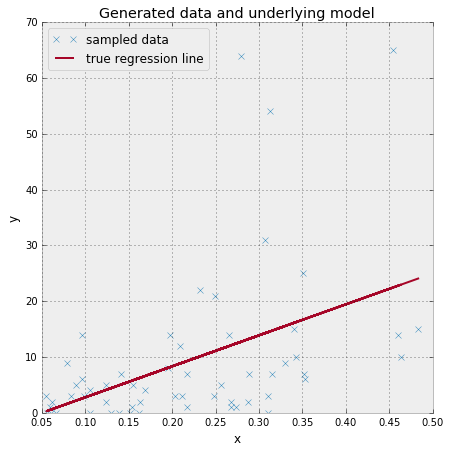

In [33]:
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, xlabel='x', ylabel='y', title='Generated data and underlying model')
ax.plot(x, y, 'x', label='sampled data')
ax.plot(x, true_regression_line, label='true regression line', lw=2.)
plt.legend(loc=0);

In [34]:
with Model() as model:
    # specify glm and pass in data. The resulting linear model, its likelihood and 
    # and all its parameters are automatically added to our model.
    glm.glm('y ~ x', data)
    start = find_MAP()
    step = NUTS(scaling=start) # Instantiate MCMC sampling algorithm
    trace = sample(2000, step, progressbar=False) # draw 2000 posterior samples using NUTS sampling

Applied log-transform to sd and added transformed sd_log to model.


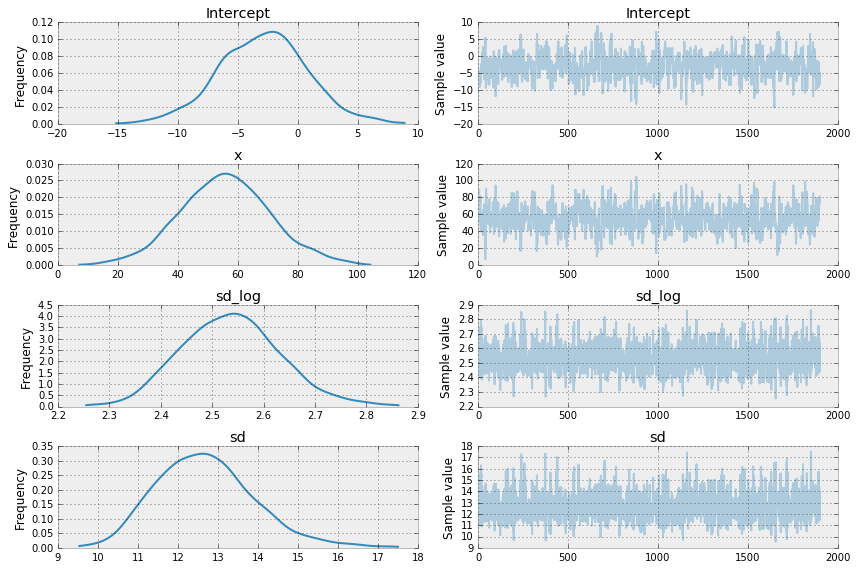

In [35]:

plt.figure(figsize=(7, 7))
traceplot(trace[100:])
plt.tight_layout();

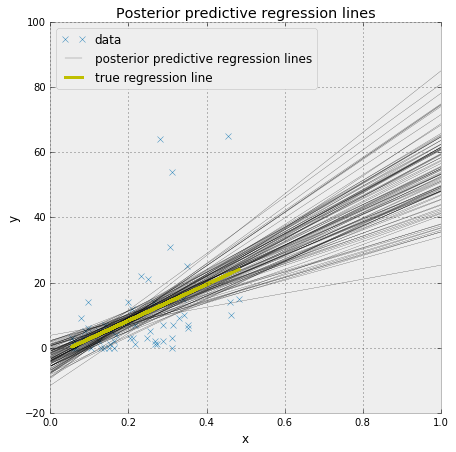

In [36]:
plt.figure(figsize=(7, 7))
plt.plot(x, y, 'x', label='data')
glm.plot_posterior_predictive(trace, samples=100, 
                              label='posterior predictive regression lines')
plt.plot(x, true_regression_line, label='true regression line', lw=3., c='y')

plt.title('Posterior predictive regression lines')
plt.legend(loc=0)
plt.xlabel('x')
plt.ylabel('y');

In [1]:
import pandas as pd

df = pd.read_csv('/Users/desert/desert_workspace/desert_data/fd_data.csv')
df = df.drop(['Unnamed: 0','State'], axis=1)
df=df.fillna(0)
df.rename(columns={'Influenza Death (<65 years of age)':'senior_flu_deaths'}, inplace=True)
df.rename(columns={'Varicella Hospitalizations':'varicella_hospitalizations'}, inplace=True)
df.head()

,County,POP2010,food_deserts,n_tracts,urban_des,rural_des,n_urban,n_rural,des_percent,perc_effected,...,varicella_hospitalizations,Salmonellosis,opiods_rx_1000,opiods_greater_than_stateavg,MILK_PRICE10,SODA_PRICE10,MILK_SODA_PRICE10,PCH_FFR_07_12,FFR07,FFR12
0,Alameda,1510271,15,360,15.0,0.0,354,6,0.041667,0.018032,...,0.132,16.978,557.20,0,1.122215,1.164422,0.891575,8.902878,1112.0,1211
1,Alpine,1175,0,1,0.0,0.0,0,1,0.000000,0.266288,...,0.000,0.000,578.68,0,1.032918,1.089488,0.877073,-50.000000,2.0,1
2,Amador,38091,0,9,0.0,0.0,0,9,0.000000,0.149514,...,0.000,7.923,1244.76,1,1.032918,1.089488,0.877073,-5.555556,18.0,17
3,Butte,220000,14,51,13.0,1.0,38,13,0.274510,0.145583,...,0.455,25.913,1389.20,1,0.996443,1.130546,0.815374,2.684564,149.0,153
4,Calaveras,45578,0,10,0.0,0.0,2,8,0.000000,0.203345,...,0.000,8.800,1068.98,1,1.032918,1.089488,0.877073,-7.407407,27.0,25


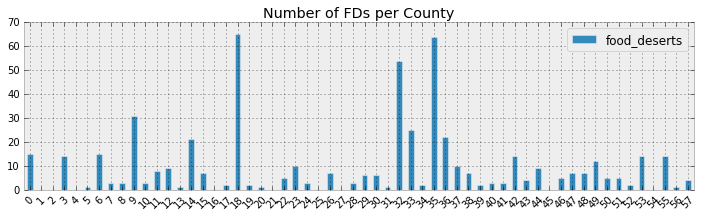

In [11]:
#/f, ax = plt.subplots(figsize=(16, 12))

df[['County','food_deserts']].plot(
    kind='bar', figsize=(12,3), title='Number of FDs per County', color=colors[0])
_ = ax.set_xlabel('county')
_ = ax.set_ylabel('Number of FDs')
_ = plt.xticks(rotation=45)

In [15]:
df.ix[18]

County                          Los Angeles
POP2010                             9818605
food_deserts                             65
n_tracts                               2334
urban_des                                65
rural_des                                 0
n_urban                                2293
n_rural                                  41
des_percent                       0.0278492
perc_effected                     0.0179679
LowIncomeTracts                        1137
low_vehicle_tracts                      210
total_housing_units                 3241204
pop_in_group_housing                 171681
pop_effected                         176420
cnty_obesity_pct                       21.3
cnty_obesity_pct_adj                   21.2
cnty_dm_pct                             7.7
cnty_dm_pct_adj                         7.8
cnty_inactive_pct                      18.1
cnty_inactive_pct_adj                  18.1
Adolescent_births                     30912
ABR                             

In [12]:
indiv_traces = {}

# Convert categorical variables to integer
le = preprocessing.LabelEncoder()
participants_idx = le.fit_transform(df['County'])
participants = le.classes_
n_participants = len(participants)

for p in participants:
    with pm.Model() as model:
        alpha = pm.Uniform('alpha', lower=0, upper=100)
        mu = pm.Uniform('mu', lower=0, upper=100)
        
        data = df[df['County']==p]['food_deserts'].values
        y_est = pm.NegativeBinomial('y_est', mu=mu, alpha=alpha, observed=data)

        y_pred = pm.NegativeBinomial('y_pred', mu=mu, alpha=alpha)
        
        start = pm.find_MAP()
        step = pm.Metropolis()
        trace = pm.sample(20000, step, start=start, progressbar=True)
        
        indiv_traces[p] = trace

Applied interval-transform to alpha and added transformed alpha_interval to model.
Applied interval-transform to mu and added transformed mu_interval to model.
 [-----------------100%-----------------] 20000 of 20000 complete in 5.3 secApplied interval-transform to alpha and added transformed alpha_interval to model.
Applied interval-transform to mu and added transformed mu_interval to model.
 [-----------------100%-----------------] 20000 of 20000 complete in 5.1 secApplied interval-transform to alpha and added transformed alpha_interval to model.
Applied interval-transform to mu and added transformed mu_interval to model.
 [-----------------100%-----------------] 20000 of 20000 complete in 5.5 secApplied interval-transform to alpha and added transformed alpha_interval to model.
Applied interval-transform to mu and added transformed mu_interval to model.
 [-----------------100%-----------------] 20000 of 20000 complete in 5.0 secApplied interval-transform to alpha and added transforme

In [13]:
fig, axs = plt.subplots(3,2, figsize=(12, 6))
axs = axs.ravel()
y_left_max = 2
y_right_max = 2000
x_lim = 100
ix = [3,4,6]

for i, j, p in zip([0,1,2], [0,2,4], df[ix]):
    axs[j].set_title('Observed: %s' % p)
    axs[j].hist(df[df['County']==p]['food_deserts'].values, range=[0, x_lim], bins=x_lim, histtype='stepfilled')
    axs[j].set_ylim([0, y_left_max])

for i, j, p in zip([0,1,2], [1,3,5], participants[ix]):
    axs[j].set_title('Posterior predictive distribution: %s' % p)
    axs[j].hist(indiv_traces[p].get_values('y_pred'), range=[0, x_lim], bins=x_lim, histtype='stepfilled', color=colors[1])
    axs[j].set_ylim([0, y_right_max])

axs[4].set_xlabel('food_deserts))
axs[5].set_xlabel('food_deserts))

#axs[5].set_xlabel('Response time (seconds)')

plt.tight_layout()

SyntaxError: EOL while scanning string literal (<ipython-input-13-43b095828b41>, line 18)

In [ ]:

combined_y_pred = np.concatenate([v.get_values('y_pred') for k, v in indiv_traces.items()])

x_lim = 60
y_pred = trace.get_values('y_pred')

fig = plt.figure(figsize=(12,6))
fig.add_subplot(211)

fig.add_subplot(211)

_ = plt.hist(combined_y_pred, range=[0, x_lim], bins=x_lim, histtype='stepfilled', color=colors[1])   
_ = plt.xlim(1, x_lim)
_ = plt.ylim(0, 20000)
_ = plt.ylabel('Frequency')
_ = plt.title('Posterior predictive distribution')

fig.add_subplot(212)

_ = plt.hist(messages['time_delay_seconds'].values, range=[0, x_lim], bins=x_lim, histtype='stepfilled')
_ = plt.xlim(0, x_lim)
_ = plt.xlabel('Response time in seconds')
_ = plt.ylim(0, 20)
_ = plt.ylabel('Frequency')
_ = plt.title('Distribution of observed data')

plt.tight_layout()